In [1]:
import torch as tr

if tr.backends.mps.is_available():
    device = tr.device("mps")
    x = tr.ones(1, device=device)
    print (x)
elif tr.cuda.is_available():
    device = tr.device("cuda")
    x = tr.ones(1, device=device)
    print (x)
else:
    print ("MPS device not found.")


MPS device not found.


In [3]:
#check if you are in the pscr directory in astral as01
#!cd pscr
#!cd pdf-data/Nf2+1/
!ls -l pdf-data/Nf2+1/

total 6965
-rwxrwxrwx. 1 yacahuanamedra physg 5779624 Oct  6 23:57 ratio.summationLinearFits.cl21_32_64_b6p3_m0p2350_m0p2050.phased-d001_2.00.hdf5
-rwxrwxrwx. 1 yacahuanamedra physg 5779624 Oct  6 23:57 ratio.summationLinearFits.cl21_32_64_b6p3_m0p2350_m0p2050.unphased.hdf5


# Define

In [2]:
from GP import *
import torch as tr
import numpy as np
import matplotlib.pyplot as plt

import scipy.integrate as integrate
from torch.special import gammaln
#from orthogonal_poly import legendre_01

from torch.autograd.functional import hessian

import scipy.integrate as integrate

import h5py as h5

# import all packages and set plots to be embedded inline
import numpy as np 
from scipy.optimize import minimize 
from scipy import special 
from scipy.optimize import Bounds 
from scipy.linalg import cho_solve 
from pyDOE import lhs 
import time
from sklearn.preprocessing import MinMaxScaler 
from sklearn.pipeline import Pipeline 
import torch as tr
import scipy.special

def get_dist_matelem(z, p, t_min):
    f = 0
    if p <= 3:
        f = h5.File('pdf-data/Nf2+1/ratio.summationLinearFits.cl21_32_64_b6p3_m0p2350_m0p2050.unphased.hdf5','r')
    else:
        f = h5.File('pdf-data/Nf2+1/ratio.summationLinearFits.cl21_32_64_b6p3_m0p2350_m0p2050.phased-d001_2.00.hdf5','r')
    M_z_p = np.array(f['MatElem/bins/Re/mom_0_0_+'+str(p)+'/disp_z+'+str(z)+'/insertion_gt/tsep_'+str(t_min)+'-14'])
    M_0_0 = np.array(f['MatElem/bins/Re/mom_0_0_0/disp_0/insertion_gt/tsep_'+str(t_min)+'-14'])
    M_z_0 = np.array(f['MatElem/bins/Re/mom_0_0_0/disp_z+'+str(z)+'/insertion_gt/tsep_'+str(t_min)+'-14'])
    M_0_p = np.array(f['MatElem/bins/Re/mom_0_0_+'+str(p)+'/disp_0/insertion_gt/tsep_'+str(t_min)+'-14'])
    
    f.close()
    return M_z_p * M_0_0 / M_0_p / M_z_0

def get_final_res(z, p):
    m_4, _ = get_dist_matelem(z, p, 4)
    m_6, s_6 = get_dist_matelem(z, p, 6)
    m_8, s_8 = get_dist_matelem(z, p, 8)
    return m_6, np.sqrt(s_6**2)#+(m_4-m_6)**2)

Np = 6
Nz = 12
Nj = 349
rMj = np.empty([Nj,Np,Nz])
nu = np.empty([Np,Nz])
for p in range(1,Np+1):
    for z in range (1,Nz+1):
        nu[p-1,z-1] = 2.0*np.pi/32.0 *p *z
        #print(p,z,nu[p-1,z-1])
        m_4 = get_dist_matelem(z,p,4)
        m_6 = get_dist_matelem(z,p,6)
        m_8 = get_dist_matelem(z,p,8)
        #expo fit
        m = (m_4*m_8 - m_6**2)/(m_4 + m_8 - 2 * m_6)
        # this fails for certain cases where the denomenator goes too close to zero
        # use the m_6 as default
        rMj[:,p-1,z-1] = m_6
        #Nj=m.shape[0]
        #print(z,p,np.mean(m_4),np.mean(m_6),np.mean(m_8), np.mean(m),np.std(m)*np.sqrt(Nj-1))
rM = np.mean(rMj,axis=0)
rMe = np.std(rMj,axis=0)*np.sqrt(Nj) 
#plot the data
#for i in range(0,6):
#    plt.errorbar(nu[i],rM[i],yerr=rMe[i],fmt='.',alpha=0.5,label='p='+str(i+1))
#plt.legend()
#plt.show()

In [3]:
##integrator
class FE_Integrator:
    def __init__(self,x):
        self.N = x.shape[0]
        xx = np.append(x,2.0*x[self.N-1] - x[self.N-2])
        self.x = np.append(0,xx)
        self.eI = 0

        self.Norm = np.empty(self.N)
        for i in range(self.N):
            self.Norm[i] = self.ComputeI(i, lambda x : 1)
            
    def pulse(self,x,x1,x2):
        return np.heaviside(x-x1,0.5)* np.heaviside(x2-x,0.5)
    
    def f(self,x,i):
 ##       if(i==0):
 ##           R=(x- self.x[2])/(self.x[1] -self.x[2])*np.heaviside(x-self.x[0],1.0)* np.heaviside(self.x[2]-x,0.5)

            #R= self.pulse(x,self.x[0],self.x[1])
            #R= (x- self.x[0])/(self.x[1] -self.x[0])*self.pulse(x,self.x[0],self.x[1])
            #R+=(x- self.x[2])/(self.x[1] -self.x[2])*self.pulse(x,self.x[1],self.x[2])
            #R+=(x- self.x[1])/(self.x[0] -self.x[1])*self.pulse(x,self.x[0],self.x[1]) 
##            return R
        ii=i+1
        R = (x- self.x[ii-1])/(self.x[ii] -self.x[ii-1])*self.pulse(x,self.x[ii-1],self.x[ii  ])
        R+= (x- self.x[ii+1])/(self.x[ii] -self.x[ii+1])*self.pulse(x,self.x[ii  ],self.x[ii+1])

       # if(i==0):
       #     R *=2
        return R
    
    def set_up_integration(self,Kernel = lambda x: 1):
        res = np.empty(self.N)
        for i in range(self.N):
            res[i] = self.ComputeI(i,Kernel)
        return res
   
    # assume symmetrix function F(x,y) = F(y,x)
    # for efficiency
    def set_up_dbl_integration(self,Kernel = lambda x,y: 1):
        res = np.empty([self.N,self.N])
        for i in range(self.N):
            for j in range(i,self.N):
                res[i,j] = self.ComputeIJ(i,j,Kernel)
                res[j,i]  = res[i,j]
        #res[0,:] *=2
        #res[:,0] *=2
        return res
        
    def ComputeI(self,i,Kernel):
        I,eI = integrate.quad(lambda x: Kernel(x)*self.f(x,i), self.x[i], self.x[i+2])
        self.eI += eI
        return I
    
    def ComputeIJ(self,i,j,Kernel):
        I,eI = integrate.dblquad(lambda x,y: self.f(x,i)*Kernel(x,y)*self.f(y,j), self.x[j], self.x[j+2],self.x[i], self.x[i+2])
        self.eI += eI
        return I
    
    
# quadratic finite elements are more complicated...
# ... but now it works!
# also I should try the qubic ones too
class FE2_Integrator:
    def __init__(self,x):
        self.N = x.shape[0]
        xx = np.append(x,[2.0*x[self.N-1] - x[self.N-2], 3.0*x[self.N-1]-2*x[self.N-2],0] )
        #self.x = np.append([-x[0],0],xx)
        self.x = np.append(0,xx)
        self.eI = 0

        self.Norm = np.empty(self.N)
        for i in range(self.N):
            self.Norm[i] = self.ComputeI(i, lambda x : 1)
            
    def pulse(self,x,x1,x2):
        return np.heaviside(x-x1,0.5)* np.heaviside(x2-x,0.5)
    
    def f(self,x,i):
        R=0.0
        if(i==0):
            #R=self.pulse(x,self.x[0],self.x[1])
            #R=self.pulse(x,self.x[1],self.x[2])
        #    R+=(x- self.x[2])/(self.x[1] -self.x[2])*self.pulse(x,self.x[1],self.x[2])

            R+=(x- self.x[2])*(x- self.x[3])/((self.x[1] -self.x[3])*(self.x[1] -self.x[2]))**np.heaviside(x-self.x[0],1.0)* np.heaviside(self.x[3]-x,0.5)
            #self.pulse(x,self.x[0],self.x[3])
            return R
        ii =i+1
        if(ii%2==0):
            R  += (x- self.x[ii-1])*(x- self.x[ii+1])/((self.x[ii] -self.x[ii+1])*(self.x[ii] -self.x[ii-1]))*self.pulse(x,self.x[ii-1],self.x[ii+1])
            return R
        else:
            R += (x- self.x[ii-2])*(x- self.x[ii-1])/((self.x[ii] -self.x[ii-2])*(self.x[ii] -self.x[ii-1]))*self.pulse(x,self.x[ii-2],self.x[ii  ])
            R += (x- self.x[ii+1])*(x- self.x[ii+2])/((self.x[ii] -self.x[ii+2])*(self.x[ii] -self.x[ii+1]))*self.pulse(x,self.x[ii  ],self.x[ii+2])
            return R
    
        return R
    
    def set_up_integration(self,Kernel = lambda x: 1):
        res = np.empty(self.N)
        for i in range(self.N):
            res[i] = self.ComputeI(i,Kernel)
        return res
        
    # assume symmetrix function F(x,y) = F(y,x)
    # for efficiency 
    def set_up_dbl_integration(self,Kernel = lambda x,y: 1):
        res = np.empty([self.N,self.N])
        for i in range(self.N):
            for j in range(i,self.N):
                res[i,j] = self.ComputeIJ(i,j,Kernel)
                res[j,i]  = res[i,j]
        return res
    
    def ComputeI(self,i,Kernel):
        #if(i==0):
        #    I,eI = integrate.quad(lambda x: Kernel(x)*self.f(x,0), self.x[0], self.x[3])
        #    self.eI += eI
        #    return I
        ii=i+1
        if(ii%2==0):
            I,eI = integrate.quad(lambda x: Kernel(x)*self.f(x,i), self.x[ii-1], self.x[ii+1])
            self.eI += eI
        else:
            I,eI = integrate.quad(lambda x: Kernel(x)*self.f(x,i), self.x[ii-2], self.x[ii+2])
            self.eI += eI
        return I
    
    def ComputeIJ(self,i,j,Kernel):
        # I need to fix the i=0 case
        ii=i+1
        jj=j+1
        if(ii%2==0):
            xx = (self.x[ii-1], self.x[ii+1])
        else:
            xx = (self.x[ii-2], self.x[ii+2])
        if(jj%2==0):
            yy = (self.x[jj-1], self.x[jj+1])
        else:
            yy = (self.x[jj-2], self.x[jj+2])
        
        I,eI = integrate.dblquad(lambda x,y: self.f(x,i)*Kernel(x,y)*self.f(y,j), yy[0], yy[1],xx[0], xx[1])
        self.eI += eI

        return I

def interp(x,q,fe):
    S = 0*x
    for k in range(fe.N):
        S+= fe.f(x,k)*q[k]
    return S


#### MODELS ####


class simple_PDF():
    def __init__(self,a,b,g): 
        self.a=a
        self.b=b
        self.g=g
        self.r = 1.0
        self.F = lambda y: (y**a*(1-y)**b*(1 + g*np.sqrt(y)))/self.r
        self.r,e = integrate.quad(self.F,0.0,1.0)  


def DPDFnormed(x,a,b):
    P=tr.tensor([a,b])
    a,b=P[0],P[1]
    dG_da,dG_db=dNorm(P)
    N=tr.exp(gammaln(a+b+2) - gammaln(a+1) - gammaln(b+1))
    dP_da=(tr.pow(x,a))*tr.pow(1-x,b)*tr.log(x) *N+dG_da*x**a*(1-x)**b
    dP_db= (tr.pow(x,a))*tr.pow(1-x,b)*tr.log(1-x) *N + dG_db*x**a*(1-x)**b
    return dP_da,dP_db

def Normalization(P):
    a,b=P[0],P[1]
    return tr.exp(gammaln(a+b+2) - gammaln(a+1) - gammaln(b+1))

def dNorm(P):
    a,b=P[0],P[1]
    dG_da= tr.exp(gammaln(a+b+2) - gammaln(a+1) - gammaln(b+1))*(tr.digamma(a+b+2) - tr.digamma(a+1))
    dG_db= tr.exp(gammaln(a+b+2) - gammaln(a+1) - gammaln(b+1))*(tr.digamma(a+b+2) - tr.digamma(b+1))
    return tr.tensor([dG_da,dG_db])


def simplePDFnormed(x,a,b):
    return tr.pow(x,a)*tr.pow(1-x,b)*tr.exp(gammaln(a+b+2) - gammaln(a+1) - gammaln(b+1))
#x**a*(1-x)**b*tr.exp(gammaln(a+b+2) - gammaln(a+1) - gammaln(b+1))


def very_simplePDFnormed(x,b):
    return (1-x)**b*tr.exp(gammaln(b+2) - gammaln(b+1))

# Posterior GP V2 with split RBF kernel
def pseudo_data(nu,a,b,g,da,db,dg,N):
    sa = np.random.normal(a,da,N)
    sb = np.random.normal(b,db,N)
    sg = np.random.normal(g,dg,N)

    D = np.zeros((N,nu.shape[0]))
    Norm=1.0
    for k in range(N):
        for i in range(nu.shape[0]):
            F =  lambda y: y**sa[k]*(1-y)**sb[k]*(1 + sg[k]*np.sqrt(y)-0.1*y)*np.cos(nu[i]*y) 
            r,e = integrate.quad(F,0.0,1.0) 
            D[k,i] = r
            if i==0:
                Norm = r
            D[k,i] = D[k,i]/Norm
    #add additional gaussian noise to break correlations
    NN = np.random.normal(0,1e-2,np.prod(D.shape)).reshape(D.shape)
    return D+NN

def autograd(func,x):
    x_tensor = x.clone().detach()
    x_tensor.requires_grad_()
    y = func(x_tensor)
    y.backward()
    return x_tensor.grad


In [4]:
def DPDFnormed(x,a,b):
    P=tr.tensor([a,b])
    a,b=P[0],P[1]
    dG_da,dG_db=dNorm(P)
    N=tr.exp(gammaln(a+b+2) - gammaln(a+1) - gammaln(b+1))
    dP_da=(tr.pow(x,a))*tr.pow(1-x,b)*tr.log(x) *N+dG_da*x**a*(1-x)**b
    dP_db= (tr.pow(x,a))*tr.pow(1-x,b)*tr.log(1-x) *N + dG_db*x**a*(1-x)**b
    return dP_da,dP_db

def Normalization(P):
    a,b=P[0],P[1]
    return tr.exp(gammaln(a+b+2) - gammaln(a+1) - gammaln(b+1))

def dNorm(P):
    a,b=P[0],P[1]
    dG_da= tr.exp(gammaln(a+b+2) - gammaln(a+1) - gammaln(b+1))*(tr.digamma(a+b+2) - tr.digamma(a+1))
    dG_db= tr.exp(gammaln(a+b+2) - gammaln(a+1) - gammaln(b+1))*(tr.digamma(a+b+2) - tr.digamma(b+1))
    return tr.tensor([dG_da,dG_db])


def simplePDFnormed(x,a,b):
    return tr.pow(x,a)*tr.pow(1-x,b)*tr.exp(gammaln(a+b+2) - gammaln(a+1) - gammaln(b+1))

#xtensor=tr.tensor(x_grid)
def model(x):
    a=x[0]
    b=x[1]
    xtensor=tr.tensor([0.5])
    return simplePDFnormed(xtensor,a,b)

In [5]:
#### Kernels #####

def KrbfMat(x,s,w):
    xx=x.view(1,x.shape[0])
    yy=x.view(x.shape[0],1)
    return s*s*tr.exp(-0.5*((xx - yy)/w)**2)


class splitRBFker():
    def __init__(self,sp,scale=1):
        self.sp =sp
        self.scale = scale
    def KerMat(self,x,s1,w1,s2,w2):
        K2 = KrbfMat(x,s2,w2) # linear
        K1 = KrbfMat(tr.log(x),s1,w1)
        sig = tr.diag(tr.special.expit(self.scale*(x-self.sp)))
        sigC = tr.eye(x.shape[0])-sig
        ##return K1+K2
        return sigC@K2@sigC + sig@K1@sig

def Sig(x,scale,sp=0.1):
    return tr.special.expit(scale*(x-sp))
def transform(s):
    return s.view(s.shape[1],1).repeat(1,s.shape[1])

#  write the last one as a function
def splitRBFkerMat(x,s1,w1,s2,w2,scale,sp=0.1,eps=1e-12):
    #plot this values and it looks like a simple rbf kernel
    #s1,w1,s2,w2,scale,sp =  1.0,0.1,1.0,2.2,1.0,.1
    K1 = KrbfMat(x,s1,w1) # linear
    K2 = KrbfMat(tr.log(x+eps),s2,w2) #log
    xx=x.view(1,x.shape[0])
    ss=Sig(xx,scale,sp)
    s=transform(ss)
    #sig=sig.view(1,sig.shape[1]).repeat(sig.shape[1],1)
    sC = 1-s
    return  s*K1*s.T +sC*K2*sC.T

#DERIVATIVES
def Krbf_ds(x,s,w):
    xx=x.view(1,x.shape[0])
    yy=x.view(x.shape[0],1)
    return 2*s*tr.exp(-0.5*((xx - yy)/w)**2)
    #return  2*s*tr.exp(-0.5*((x.view(1,x.shape[0]) - x.view(x.shape[0],1))/w)**2)
def Krbf_dw(x,s,w):
    xx=x.view(1,x.shape[0])
    yy=x.view(x.shape[0],1)
    return s*s*tr.exp(-0.5*((xx - yy)/w)**2)*(xx-yy)**2/((w**3))

def sig_ds(x,scale,sp=0.1):
    sig = tr.special.expit(scale*(x.view(1,x.shape[0])-sp))
    return sig*(1-sig)

def Kcom_ds1(x,s1,w1,s2,w2,scale,sp=0.1,eps=1e-12):
    sig = tr.special.expit(scale*(x.view(1,x.shape[0])-sp))
    sig=sig.view(sig.shape[1],1).repeat(1,sig.shape[1])
    #sigC = 1-sig
    return sig*Krbf_ds(x,s1,w1)*sig.T
def Kcom_dw1(x,s1,w1,s2,w2,scale,sp=0.1,eps=1e-12):
    sig = tr.special.expit(scale*(x.view(1,x.shape[0])-sp))
    sig=sig.view(sig.shape[1],1).repeat(1,sig.shape[1])
    #sigC = 1-sig
    return sig*Krbf_dw(x,s1,w1)*sig.T
def Kcom_ds2(x,s1,w1,s2,w2,scale,sp=0.1,eps=1e-15):
    sig = tr.special.expit(scale*(x.view(1,x.shape[0])-sp))
    sig=sig.view(sig.shape[1],1).repeat(1,sig.shape[1])
    sigC = 1-sig
    return sigC*Krbf_ds(tr.log(x+eps),s2,w2)*sigC.T
def Kcom_dw2(x,s1,w1,s2,w2,scale,sp=0.1,eps=1e-12):
    sig = tr.special.expit(scale*(x.view(1,x.shape[0])-sp))
    sig=sig.view(sig.shape[1],1).repeat(1,sig.shape[1])
    sigC = 1-sig
    return sigC*Krbf_dw(tr.log(x+eps),s2,w2)*sigC.T

def sig_ds(x,scale,sp=0.1):
    return tr.exp(-scale*(x-sp))*(x-sp)*tr.special.expit(scale*(x-sp))**2

def Kcom_ds(x,s1,w1,s2,w2,scale,sp=0.1,eps=1e-12):
    K2=KrbfMat(tr.log(x+eps),s2,w2)
    K1=KrbfMat(x,s1,w1)
    xx=x.view(1,x.shape[0])
    yy=x.view(x.shape[0],1)
    ##vectors
    ssx=Sig(xx,scale,sp)
    ssy=Sig(yy,scale,sp)
    #transform into matrix
    sx=transform(ssx)
    sy=transform(ssy.T)

    dssx=sig_ds(xx,scale,sp)
    dssy=sig_ds(yy,scale,sp)
    #transform into matrix
    dsx=transform(dssx)
    dsy=transform(dssy.T)

    F1=((-1+sy.T)*dsx + (sx-1)*dsy.T)*K2
    F2=((dsx)*sy.T + sx*(dsy.T))*K1
    return F1+F2

def R(z,t):
    return 1.0/tr.sqrt(1-2*z*t+t*t)

def jacobi(x,s,t,a,b):
   x=x.view(x.shape[0],1)
   y=x.view(1,x.shape[0])
   return (s**2)*(x*y)**a*((1-x)*(1-y))**b*(R(2*x-1,t)*R(2*y-1,t)*((1-t+R(2*x-1,t))*(1-t+R(2*y-1,t)))**a*((1+t+R(2*x-1,t))*(1+t+R(2*y-1,t)))**b)**(-1)#+1e-6*tr.eye(x.shape[0])
   #return s*(x.view(1,x.shape[0])*x.view(x.shape[0],1))**a*((1-x.view(1,x.shape[0]))*(1-x.view(x.shape[0],1)))**b*(R(2*x.view(1,x.shape[0])-1,t)*R(2*x.view(x.shape[0],1)-1,t)*((1-t+R(2*x.view(1,x.shape[0])-1,t))*(1-t+R(2*x.view(x.shape[0],1)-1,t)))**a*((1+t+R(2*x.view(1,x.shape[0])-1,t))*(1+t+R(2*x.view(x.shape[0],1)-1,t)))**b)**(-1)

#plot the trace1
def plotrace(trace,burn=100,kernel='jacobi'):
    fig, ax = plt.subplots(trace.shape[1],figsize=(20, 8))
    i0 = burn
    iF=trace.shape[0]
    if kernel=='jacobifull':
        lab=['α', 'β','s','t','a','b']
    elif kernel=='jacobi':
        lab=['s','t','a','b']
    else:
        lab=['α', 'β','σ1','w1','σ2','w2','s','σerror']
    col=['red','blue','green','pink','black','orange','purple','brown']
    for i in range(trace.shape[1]):
        ax[i].plot(trace[i0:iF,i],label=lab[i],color=col[i])
        ax[i].legend()
    plt.show()

def plothist(trace,mygp,disc,prior=False,burn=100,kernel='jacobi'):
    fig, ax = plt.subplots(trace.shape[1], 1, figsize=(10, 10), sharex=False, sharey=False)
    i0 = 100
    iF=10000
    if kernel=='jacobifull':
        lab=['α', 'β', 's', 't', 'a', 'b']
        labprior=['α-prior', 'β-prior', 's-prior', 't-prior', 'a-prior', 'b-prior']
    elif kernel=='jacobi':
        lab=['s','t','a','b']
        labprior=['s-prior','t-prior','a-prior','b-prior']
    else:
        lab=['α','β','σ1','w1','σ2','w2','s','σerror']
        labprior=['α-prior','β-prior','σ1-prior','w1-prior','σ2-prior','w2-prior','s-prior','σerror-prior']
    col=['red','blue','green','pink','black','orange','purple','brown']


    for i in range(trace.shape[1]):
        ax[i].hist(trace[i0:iF,i],bins=disc,label=lab[i],color=col[i],density=True)
        if prior:
            initial=mygp.prior_dist[i].shift
            final=mygp.prior_dist[i].shift+mygp.prior_dist[i].scale
            xxx = tr.linspace(initial,final,1000)
            distexp=mygp.prior_dist[i]
            pdfs=tr.zeros(xxx.shape[0])
            for k in range(xxx.shape[0]):
                pdfs[k]=distexp.pdf(xxx[k])
            ax[i].plot(xxx,pdfs.detach().numpy())
            ax[i].set_xlim([initial-0.5,final+0.5])
        ax[i].legend()
    plt.show()


def RBF(x,s,w):
    return s*s*tr.exp(-0.5*((x.view(1,x.shape[0]) - x.view(x.shape[0],1))/w)**2)


#from tensor to list
def tensor2list(tensor):
    return [tensor[i].item() for i in range(tensor.shape[0])]

Nx=256
x_grid = np.concatenate((np.logspace(-12,-1,np.int32(Nx/2)),np.linspace(0.1+1e-4,1-1e-12,np.int32(Nx/2))))

## Kernel

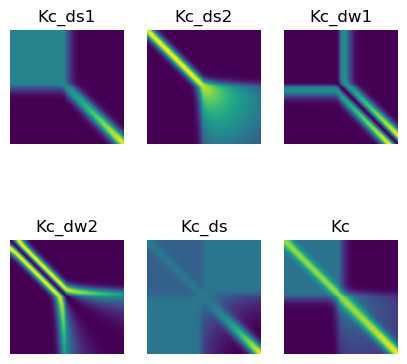

In [8]:
#plot Kcom_ds
device="cpu"
x=tr.tensor(x_grid,dtype=tr.float32).to(device)
s1,w1,s2,w2,scale,sp =  1.0,.1,1.0,2.2,1.0,.1
fig, ax= plt.subplots(2,3,figsize=(5, 5))
Ks1=Kcom_ds1(x,s1,w1,s2,w2,scale,sp)
Kw1=Kcom_dw1(x,s1,w1,s2,w2,scale,sp)
Ks2=Kcom_ds2(x,s1,w1,s2,w2,scale,sp)
Kw2=Kcom_dw2(x,s1,w1,s2,w2,scale,sp)
Ks=Kcom_ds(x,s1,w1,s2,w2,scale,sp)
K=splitRBFkerMat(x,s1,w1,s2,w2,scale,sp)
dK=[Ks1,Kw1,Ks2,Kw2,Ks,K]
#title of the plot

ax[0,0].imshow(Ks1.cpu())
ax[0,0].set_title('Kc_ds1')
ax[0,1].imshow(Ks2.cpu())
ax[0,1].set_title('Kc_ds2')
ax[0,2].imshow(Kw1.cpu())
ax[0,2].set_title('Kc_dw1')
ax[1,0].imshow(Kw2.cpu())
ax[1,0].set_title('Kc_dw2')
ax[1,1].imshow(Ks.cpu())
ax[1,1].set_title('Kc_ds')
ax[1,2].imshow(K.cpu())
ax[1,2].set_title('Kc')

#erase scale in axes
for i in range(2):
    for j in range(3):
        ax[i,j].axis('off')

# Test probabilities

In [13]:
mean= tr.tensor([2.10])
cov = tr.tensor([1.1])
dist=[]
for i in range(1):
    dist.append(lognormal(mean,cov,device="cpu",shift=1.0))
    print(dist[i].pdf(tr.tensor([0.1])),dist[i].pdf(tr.tensor([0.1])))

def UU(xx):
    return -tr.log(dist[0].pdf(xx))

sampler=HMC_sampler(UU,diagonal=tr.tensor([1.0]),device="cpu")
sampler.q0=tr.tensor([0.1],requires_grad=True)
qs,ps,H=sampler.sample(tr.tensor([0.1]),5000,1/10,10)

tensor([0.0626]) tensor([0.0626])


100%|██████████| 4999/4999 [00:21<00:00, 230.66it/s]


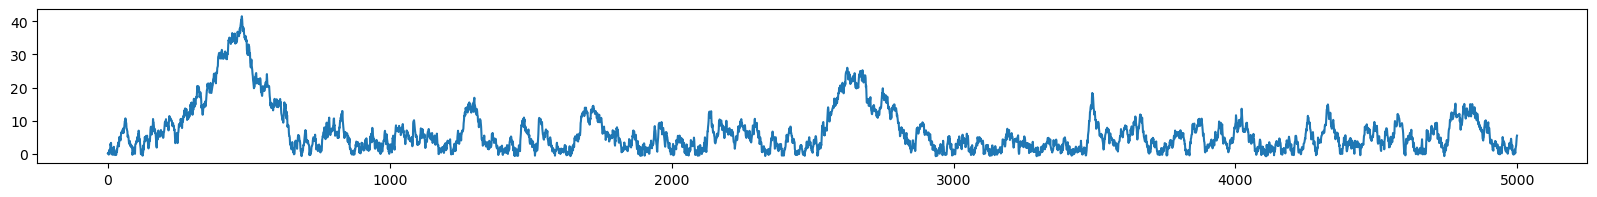

In [14]:
fig, ax = plt.subplots(1, figsize=(20, 2), sharex=False, sharey=False)
ax.plot(qs.detach().numpy())
plt.show()

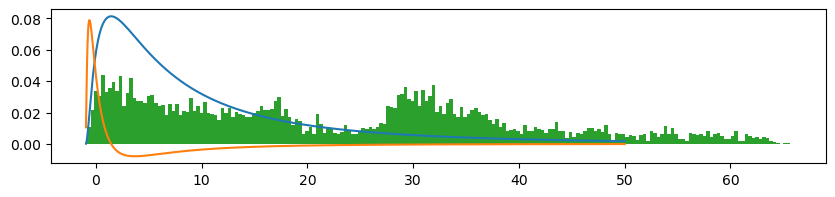

In [11]:
#histogram
qs1=qs[:].detach().numpy()
x = tr.linspace(-1.0,50,1000)
fig, ax = plt.subplots(1,figsize=(10, 2))
pdfs=tr.zeros(x.shape[0])
dpdfs=tr.zeros(x.shape[0])
for i in range(x.shape[0]):
    pdfs[i]=dist[0].pdf(x[i])
    dpdfs[i]=dist[0].dpdf(x[i])
ax.plot(x,pdfs)
ax.plot(x,dpdfs)
ax.hist(qs1.T[qs1.T>-dist[0].shift],bins=200,density=True)
plt.show()

In [12]:
from GP import expbeta

100%|██████████| 9999/9999 [01:30<00:00, 110.81it/s]


Time to sample 90.23425149917603


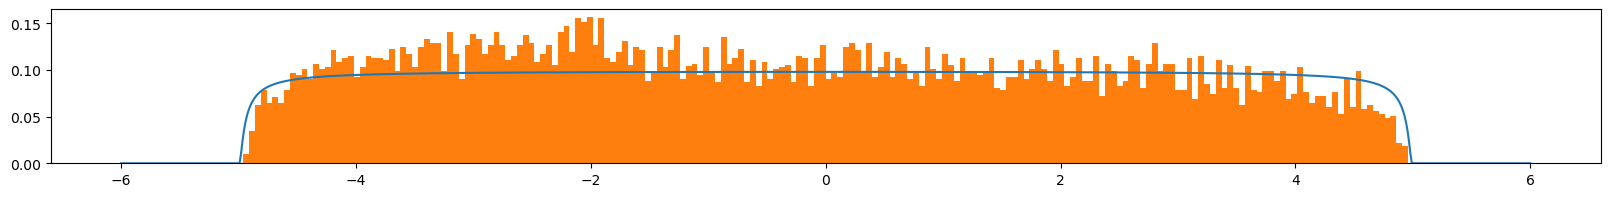

In [13]:
xxx = tr.linspace(-6.,6.,1000)
distexp=expbeta(-.99,-.99,-5.0,10.0)
pdfs=tr.zeros(xxx.shape[0])
dpdfs=tr.zeros(xxx.shape[0])
for i in range(xxx.shape[0]):
    pdfs[i]=distexp.pdf(xxx[i])
    dpdfs[i]=distexp.dpdf(xxx[i])
#sample in the mean 
qqq=distexp.shift+distexp.scale*0.5
start= time.time()
sampler1=HMC_sampler(distexp.nlogpdf,diagonal=tr.tensor([0.3]))
sampler1.q0=tr.tensor([qqq],requires_grad=True)
qs,ps,H=sampler1.sample(tr.tensor([qqq]),10000,1/20,20)
end= time.time()
print("Time to sample",end-start)
#plot
fig, ax = plt.subplots(1, figsize=(20, 2), sharex=False, sharey=False)
ax.plot(xxx.detach().numpy(),pdfs.detach().numpy())
ax.hist(qs.detach().numpy(),bins=200,density=True)
plt.show()


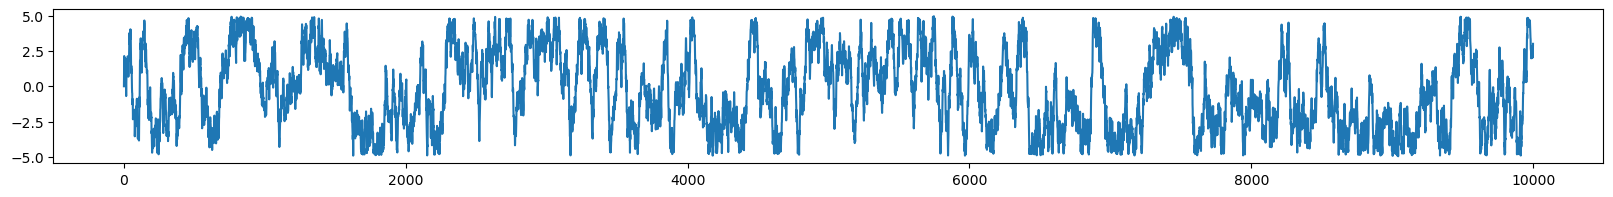

In [14]:
fig, ax = plt.subplots(1, figsize=(20, 2), sharex=False, sharey=False)
ax.plot(qs.detach().numpy())
plt.show()

rejected in leapfrog 2
rejected in leapfrog 2
rejected in leapfrog 2
rejected in leapfrog 2
rejected in leapfrog 2
rejected in leapfrog 2
rejected in leapfrog 2
rejected in leapfrog 2
rejected in leapfrog 2
rejected in leapfrog 2
rejected in leapfrog 2
rejected in leapfrog 2
rejected in leapfrog 2
rejected in leapfrog 2
rejected in leapfrog 2
rejected in leapfrog 2
rejected in leapfrog 2
rejected in leapfrog 2
rejected in leapfrog 2
rejected in leapfrog 2
rejected in leapfrog 2
rejected in leapfrog 2
rejected in leapfrog 2
rejected in leapfrog 2
rejected in leapfrog 2
rejected in leapfrog 2
rejected in leapfrog 2
rejected in leapfrog 2
rejected in leapfrog 2
rejected in leapfrog 2
rejected in leapfrog 2
rejected in leapfrog 2
rejected in leapfrog 2
rejected in leapfrog 2
rejected in leapfrog 2
rejected in leapfrog 2
rejected in leapfrog 2
rejected in leapfrog 2
rejected in leapfrog 2
rejected in leapfrog 2
rejected in leapfrog 2
rejected in leapfrog 2
rejected in leapfrog 2
rejected in

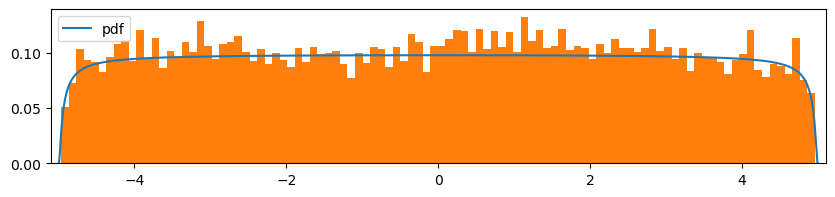

In [39]:
#plot pdf and dpdf
xxx = tr.linspace(-5.,5.,1000)
distexp=expbeta(-.990,-.990,-5.0,10.0)
pdfs=tr.zeros(xxx.shape[0])
dpdfs=tr.zeros(xxx.shape[0])
#time 
start = time.time()
trace=distexp.sample(10000)
end= time.time()
print('Time to sample',end-start)
for i in range(xxx.shape[0]):
    pdfs[i]=distexp.pdf(xxx[i])
    dpdfs[i]=distexp.dpdf(xxx[i])
fig, ax = plt.subplots(1,figsize=(10, 2))
ax.plot(xxx,pdfs.detach().numpy(),label='pdf')
#ax.plot(xxx,dpdfs.detach().numpy(),label='dpdf')
ax.hist(trace.detach().numpy(),bins=100,density=True)
#range of the plot
ax.set_xlim([-5.1,5.1])
#ax.set_ylim([-1,1])
ax.legend()
plt.show()

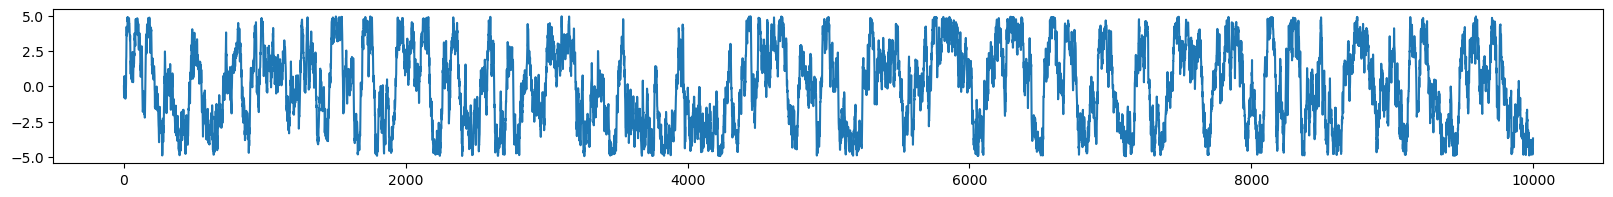

In [40]:
fig, ax = plt.subplots(1, figsize=(20, 2), sharex=False, sharey=False)
ax.plot(trace.detach().numpy())
plt.show()

In [15]:
#size qs in mbytes
qs1.nbytes/1e6 *8

0.16

# How to use it?
## Define prior and load data
Construct the GP object and prepare the data ($K_{comb}(x,y,\sigma_{1,2},w_{1,2},s)$)

In [6]:
#set up input data
def preparedata(i,nu,rMj,rMe,rM):
    #prepare the data
    Nnu = nu.shape[1]
    CovD= np.corrcoef(rMj[:,:,i-1].T)#*(rMj[:,:,i-1].T.shape[0]-1)
    CovD =tr.tensor( (CovD + CovD.T)/2)
    M = rM.T[i]
    eM = rMe.T[i]
    n = nu.T[i]
    Nx=256
    x_grid = np.concatenate((np.logspace(-12,-1,np.int32(Nx/2)),np.linspace(0.1+1e-4,1-1e-12,np.int32(Nx/2))))
    fe = FE2_Integrator(x_grid)
    lam = 1e-5   # soften the constrants
    lam_c = 1e-5
    B0 = fe.set_up_integration(Kernel=lambda x: 1)
    B1 = np.zeros_like(B0) 
    B1[-1] = 1.0 # x=1 is at the end...
    n # is the nu values at current z
    B = np.zeros((n.shape[0],Nx))
    for k in np.arange(n.shape[0]):
        B[k,:] = fe.set_up_integration(Kernel= lambda x : np.cos(n[k]*x))
    V = np.concatenate((B0[np.newaxis,:],B1[np.newaxis,:],B))
    Gamma = np.zeros((V.shape[0],V.shape[0]))
    Gamma[0,0] = lam
    Gamma[1,1] = lam_c
    Gamma[2:,2:] = CovD
    Y = np.concatenate(([1,0],M))
    return x_grid,V,Y,Gamma

In [7]:
fits_comb=[]
sss=tr.tensor([1.0,0.2,1.0,5.1,1.0,2.2,1.0])
mmm=tr.tensor([-0.5,1.5,1.0,.1,1.0,2.2,1.0])
print("0=gaussian, 1=lognormal, 2=expbeta")
for i in range(0,nu.shape[1]):
    x_gri0,V0,Y0,Gamma0 = preparedata(i,nu,rMj,rMe,rM)
    myGP0= GaussianProcess(x_gri0,V0,Y0,Gamma0,f"z={i+1}a",flag="noiseless",device="cpu",Pd=simplePDFnormed, Ker=splitRBFkerMat,Pd_args=(-0.0,1.0),Ker_args=(5.0,1.1,5.0,1.1,4.0))
    myGP0.prior2ndlevel("all",1000,mean=tr.tensor([-1.0,0.0,0.0,-10.0,0.0,-10.0,-5.0]),sigma=tr.tensor([2.0,5.0,10.0,20.0,10.0,20.0,10.0]),prior_mode=tr.tensor([2,2,2,2,2,2,2]))
    fits_comb.append(myGP0)
    print(fits_comb[i].name, "done")

0=gaussian, 1=lognormal, 2=expbeta


/sciclone/pscr/yacahuanamedra/GP.py:492: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.shift=tr.tensor(shift).to(device)
/sciclone/pscr/yacahuanamedra/GP.py:493: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.scale=tr.tensor(scale).to(device)


z=1a done
z=2a done
z=3a done
z=4a done
z=5a done
z=6a done
z=7a done
z=8a done
z=9a done
z=10a done
z=11a done
z=12a done


### Training phase (to accelerate HMC)

In [8]:
#train 
start=time.time()
for i in range(0,nu.shape[1]):
    fits_comb[i].train(10000,lr=1e-2,mode='all')
    print(tr.tensor(fits_comb[i].pd_args+ fits_comb[i].ker_args))
end=time.time()
print("time",end-start)


Training everything
tensor([-6.2293e-01,  1.3061e+00, -5.8050e-06,  3.8140e+00,  3.6870e-06,
        -2.5488e-01,  7.4196e-01])
Training everything
tensor([-6.2321e-01,  1.1754e+00,  3.5917e-04,  3.7783e+00, -1.6986e-04,
         3.0844e-01,  1.1539e+00])
Training everything
tensor([-6.3025e-01,  9.0714e-01,  3.1868e-04,  3.7954e+00,  4.7706e-08,
         1.1482e-02,  9.6345e-01])
Training everything
tensor([-3.8872e-01,  1.5908e+00, -8.3980e-18,  3.7321e+00,  0.0000e+00,
         2.2346e-02, -1.3014e-01])
Training everything
tensor([-1.0802e-01,  2.3549e+00,  4.6439e-05,  3.7184e+00, -2.7595e-03,
         8.9400e-03,  9.7584e-01])
Training everything
tensor([ 1.7608e-01,  3.1347e+00, -1.7562e-07,  3.6888e+00,  2.3389e-07,
         1.1075e-02,  1.2996e+00])
Training everything
tensor([ 4.3622e-01,  3.8747e+00,  7.7789e-04,  3.6929e+00, -1.1906e-03,
         1.1095e-02,  1.4660e+00])
Training everything
tensor([ 6.4004e-01,  4.4798e+00, -5.7699e-17,  3.7089e+00,  0.0000e+00,
         2.

In [ ]:
tr.tensor([ 0.4414,  2.3653,  3.0070,  0.0267,  1.9677, -9.0420, -4.0707])

### plots with training

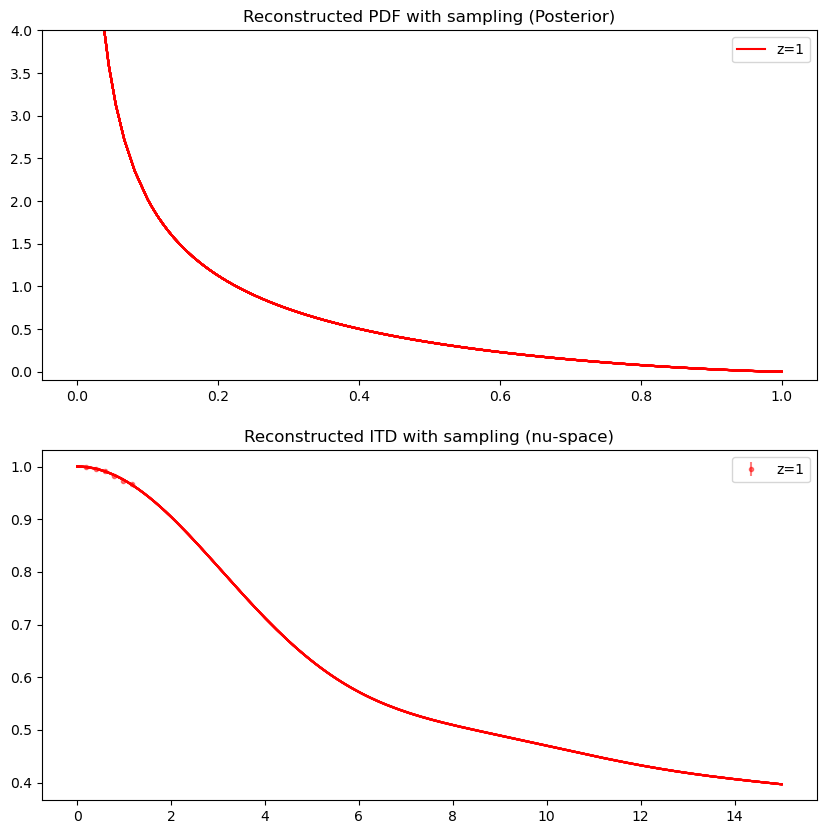

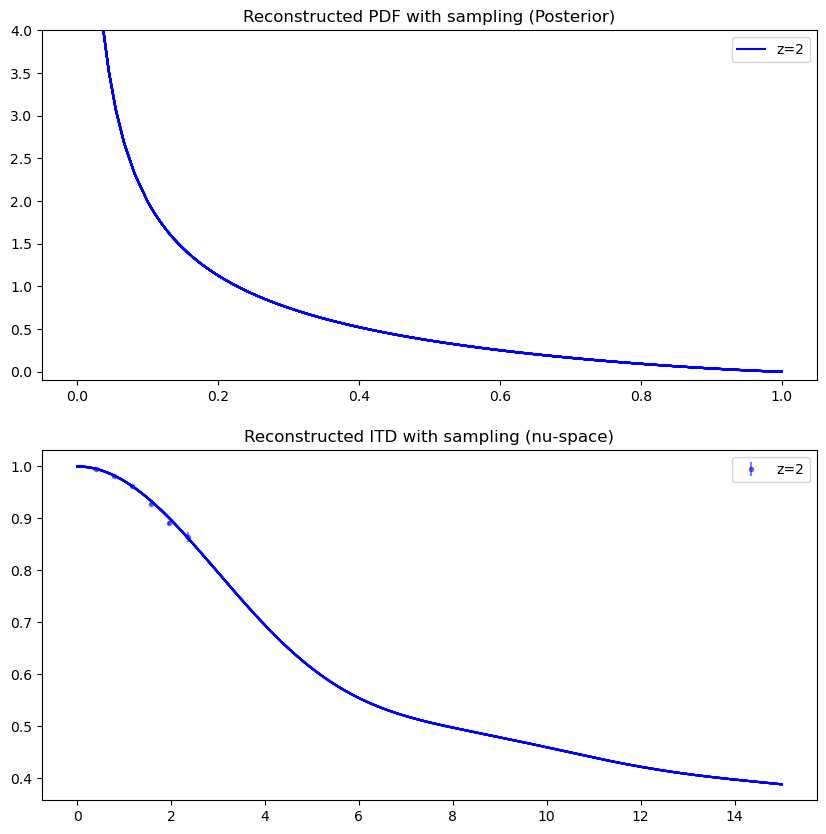

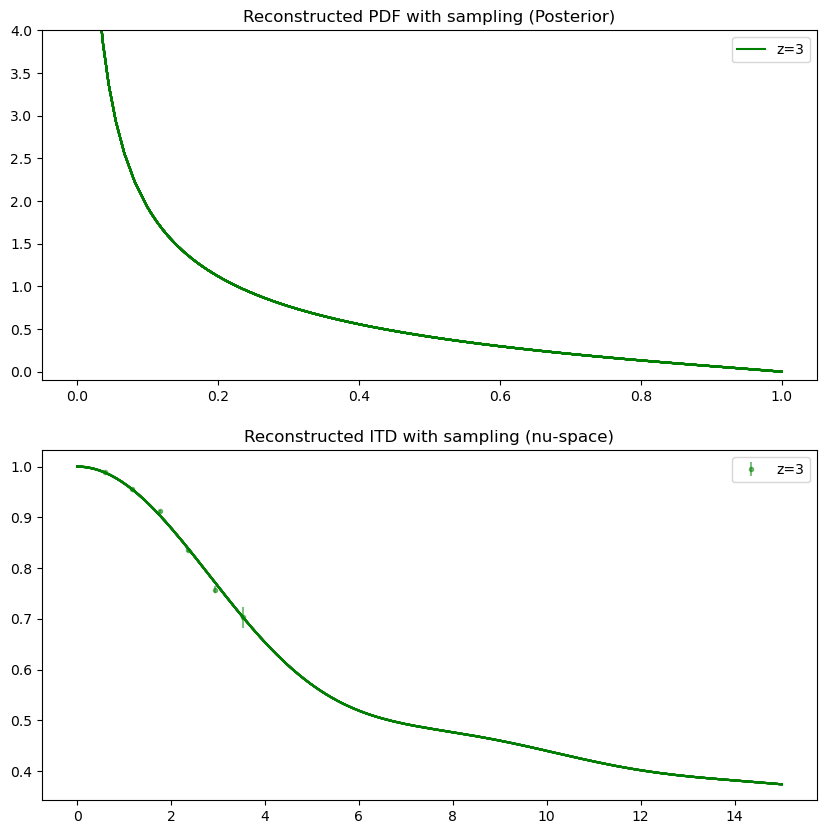

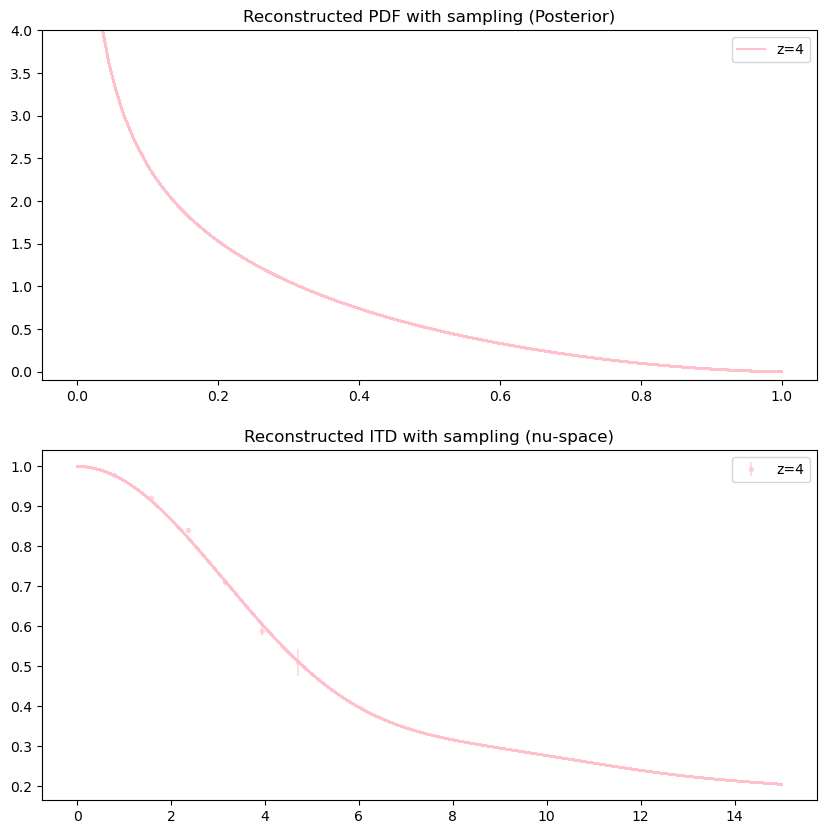

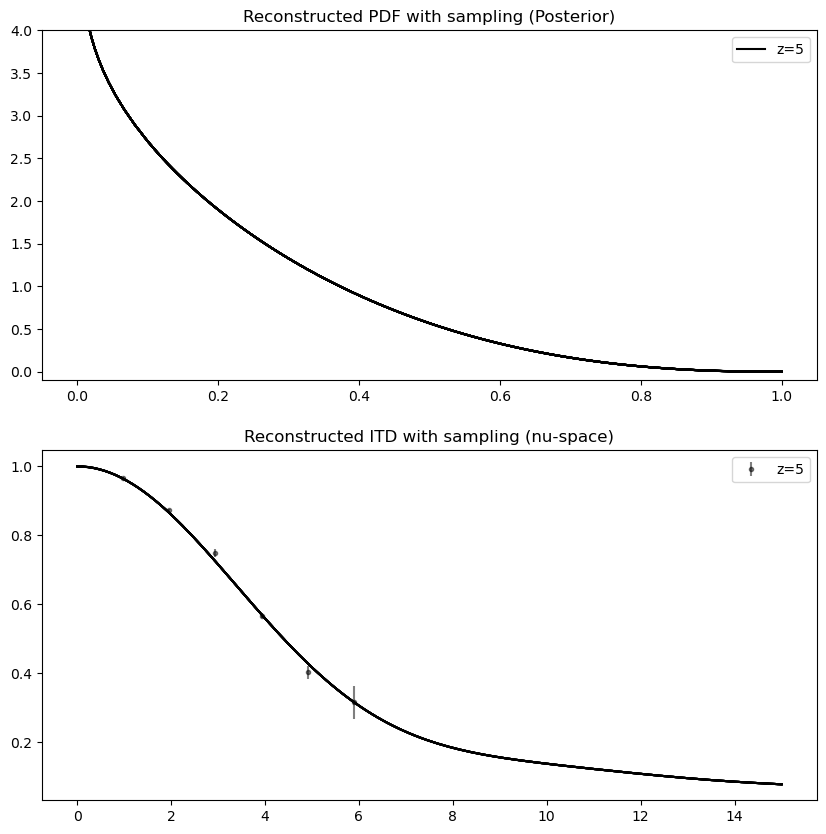

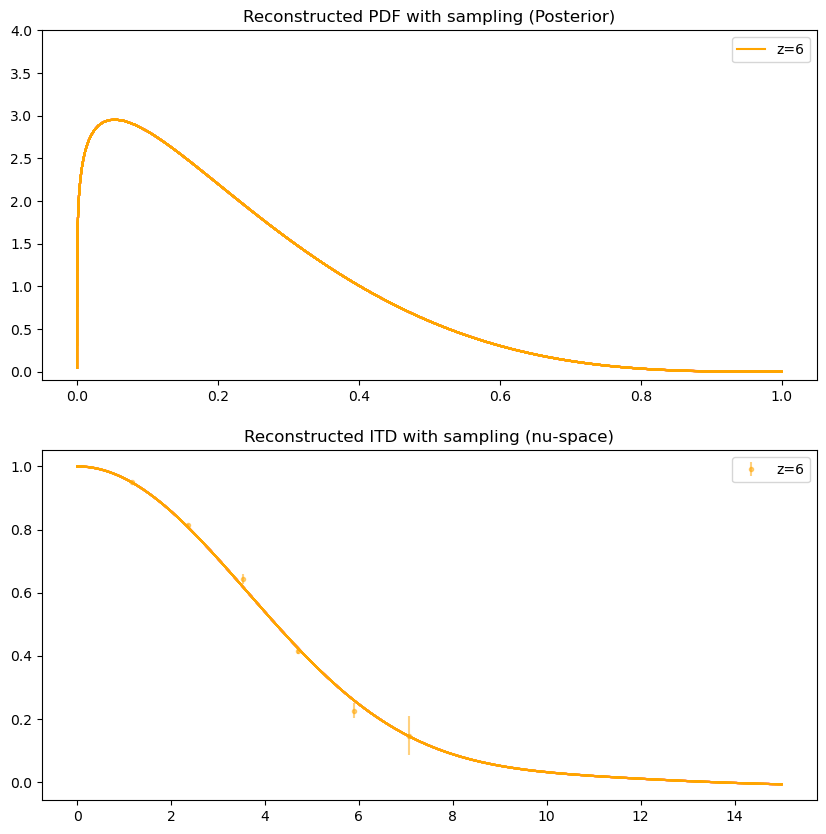

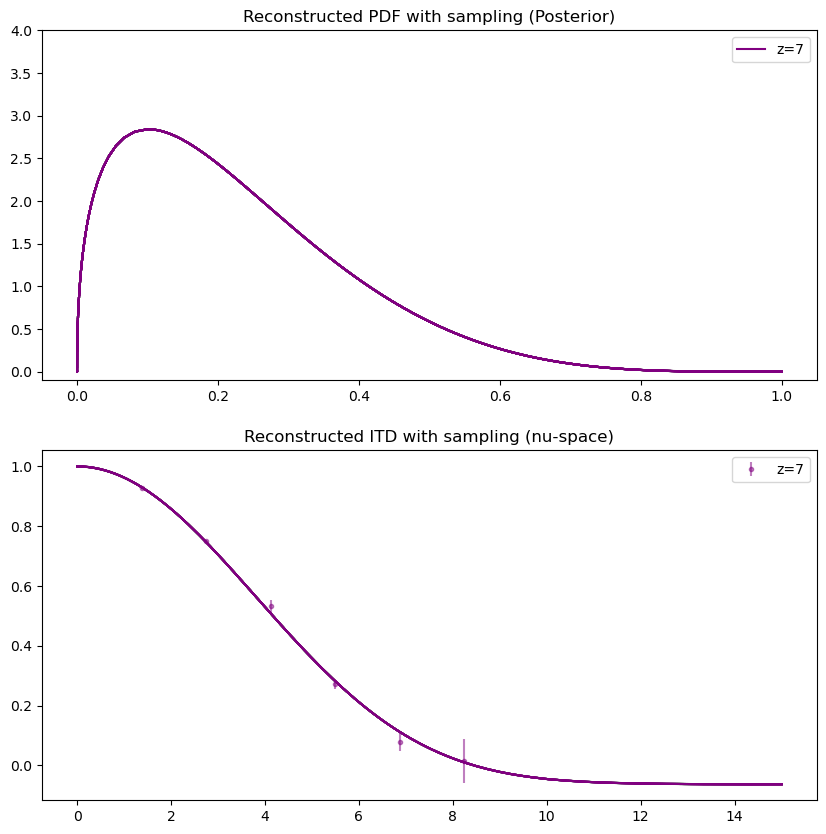

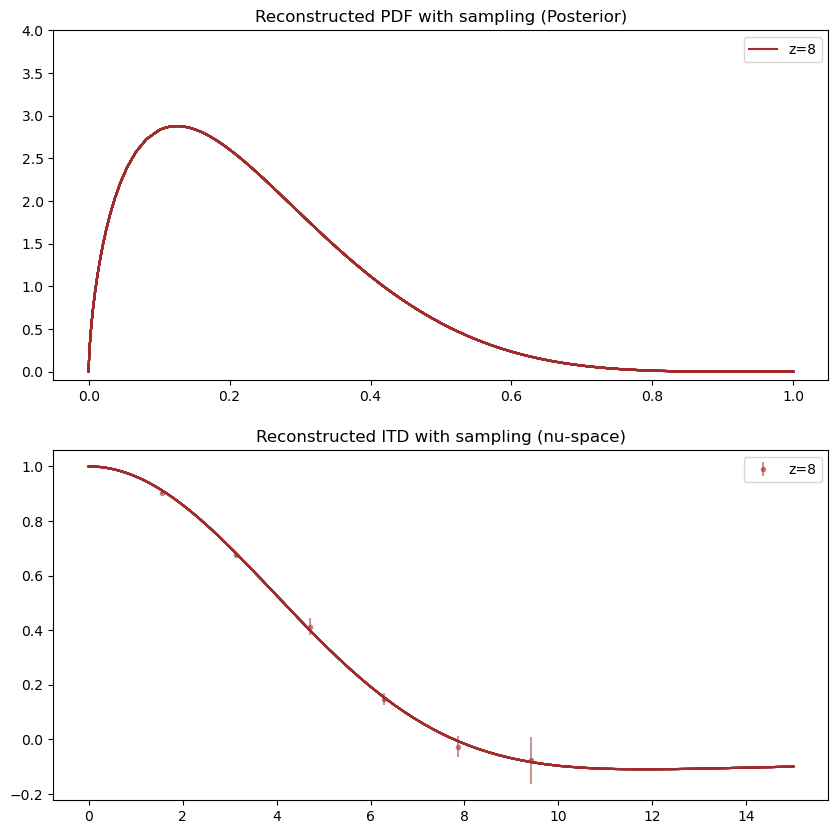

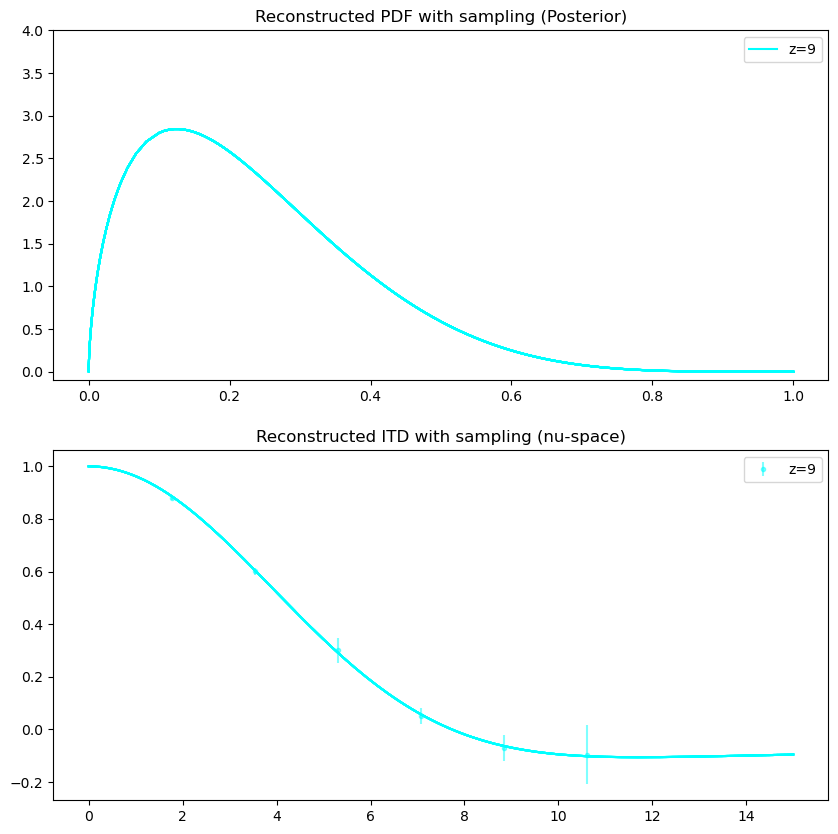

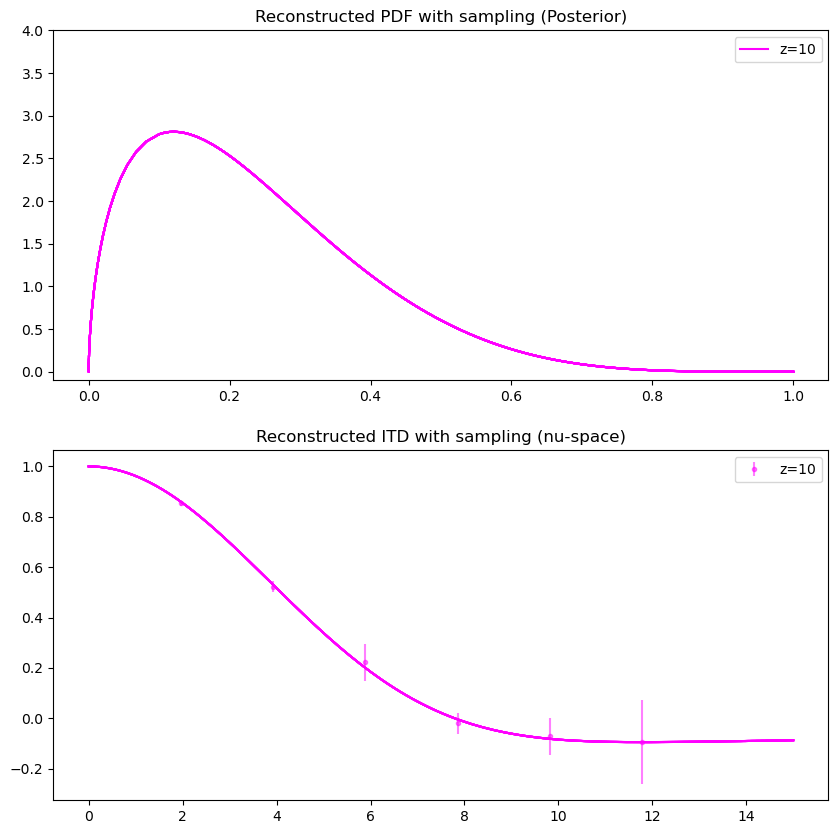

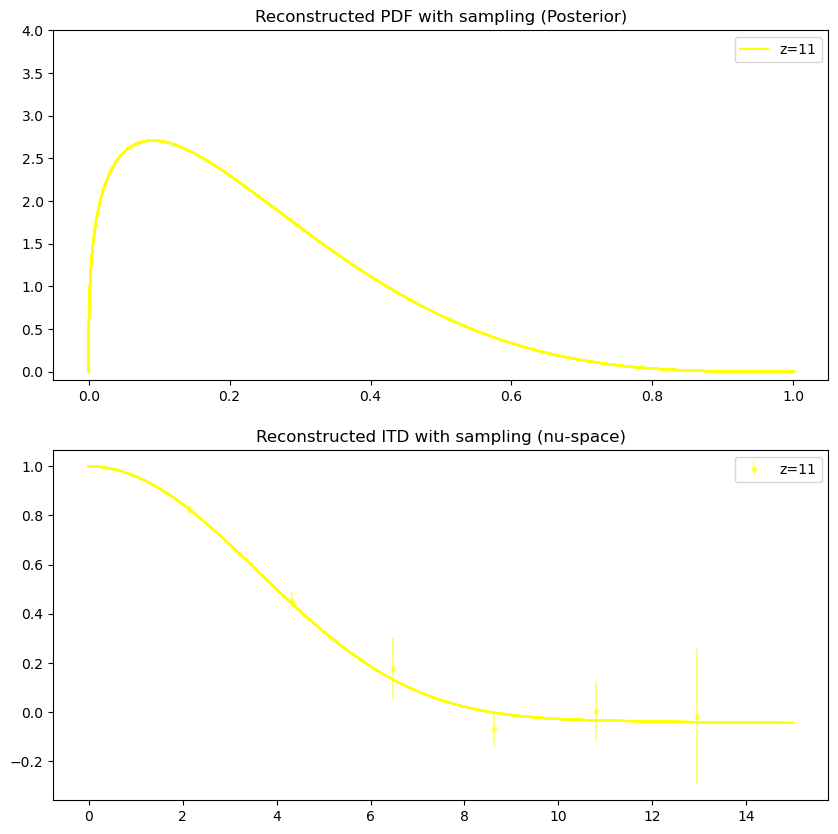

In [14]:
col=['red','blue','green','pink','black','orange','purple','brown','cyan','magenta','yellow','grey']
for i in range(11):
    if i==12:
        continue
    else:
        fig, ax= plt.subplots(2,figsize=(10, 10))
        ax[0].set_title("Reconstructed PDF with sampling (Posterior)")
        ax[1].set_title("Reconstructed ITD with sampling (nu-space)")
        fe = FE2_Integrator(x_grid)
        p,Cp = fits_comb[i].ComputePosterior()
        p,Cp = p.to("cpu"),Cp.to("cpu")
        Cp = 0.5*(Cp+Cp.T) +1e-7*tr.eye(Cp.shape[0])
        Mc=tr.distributions.MultivariateNormal(p,covariance_matrix=Cp)
        #plot the data
        pdfMc = Mc.sample((100,))
        ax[0].plot(x_grid,pdfMc.T.numpy(),alpha=0.1,color=col[i])
        ax[0].plot(x_grid,fits_comb[i].Pd(fits_comb[i].x_grid.cpu(),*fits_comb[i].pd_args).numpy(),label='z='+str(i+1),color=col[i])
        perror=1.96*np.diag(Cp)**(0.5)
        p=fits_comb[i].Pd(fits_comb[i].x_grid.cpu(),*fits_comb[i].pd_args).numpy()
        ax[0].fill_between(x_grid, p - perror, p + perror, facecolor=col[i], alpha=0.3)
        
        ax[0].legend()
        ax[0].set_ylim([-0.1,4])
        #ax[0].ylim([-0.1,4])
        nn = np.linspace(0,15,128)
        iB = np.zeros((nn.shape[0],Nx))
        for k in range(nn.shape[0]):
            iB[k,:] = fe.set_up_integration(Kernel= lambda x : np.cos(nn[k]*x))
        ttQ = pdfMc.numpy()@iB.T
        mttQ = ttQ.mean(axis=0)
        ax[1].plot(nn,ttQ.T,color=col[i],alpha=0.05)
        ax[1].plot(nn,mttQ,color=col[i])
        
        plt.errorbar(nu.T[i],rM.T[i],yerr=rMe.T[i],fmt='.',alpha=0.5,label='z='+str(i+1),color=col[i])
        plt.legend()
        plt.show()

In [11]:
tr.isinf(myGP0.post2levelpdf(GPsampler.q0.to(device)))

tensor([False], device='cuda:0')

### Samplers 

In [ ]:
##run in parallel?
momentum=tr.tensor([0.2,0.5,1.0,2.0,1.0,2.0,1.0])
samplers=[]
for i in range(0,nu.shape[1]):
    #GPsampler=HMC_sampler(myGP0.nlogpost2levelpdf,grad=myGP0.gradlogpost2levelpdf,diagonal=momentum)
    GPsampler=HMC_sampler(fits_comb[i].nlogpost2levelpdf,device="cpu",diagonal=momentum,grad=None)
    rand=tr.rand(7)*5
    #GPsampler.q0=rand
    GPsampler.q0=tr.tensor(fits_comb[i].pd_args+ fits_comb[i].ker_args).to("cpu")+0.02#+ (fits_comb[i].sig,))
    samplers.append(GPsampler)
    print(fits_comb[i].name,"sampler done")

z=1a sampler done
z=2a sampler done
z=3a sampler done
z=4a sampler done
z=5a sampler done
z=6a sampler done
z=7a sampler done
z=8a sampler done
z=9a sampler done
z=10a sampler done
z=11a sampler done
z=12a sampler done


In [12]:
import os
os.cpu_count()

32

In [17]:
i=9
start=time.time()
traceq,tracep,traceH=samplers[i].sample(samplers[i].q0,70000,1.0/400,200)
end=time.time()
print("time",end-start)

100%|███████████████████████████████████████████████████████████████████████████████████████████| 69999/69999 [35:05:41<00:00,  1.80s/it]

time 126341.93669939041


In [18]:
#save tensor
tr.save(traceq,'Kc(i=9).pt')

In [29]:
#storage size of the tensor
traceq.nbytes/1e6 *8

22.4

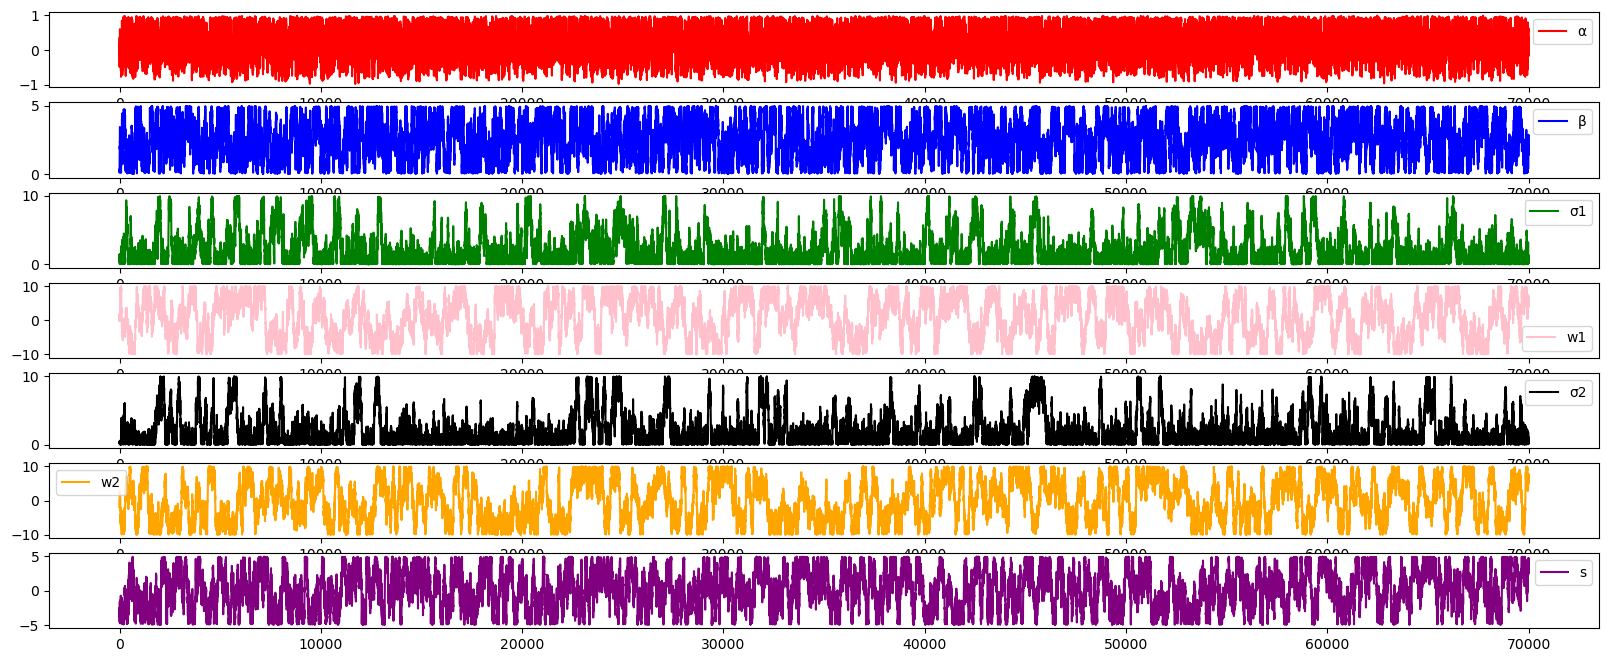

In [19]:
plotrace(traceq[0:100000].cpu(),0,kernel='splitrbf')

In [31]:
import statistics as st
traceq[:20000].mean(0),samplers[9].q0,st.mode(tensor2list(traceq[:,1:2].detach().numpy()))

(tensor([ 0.1863,  2.4860,  2.1932,  0.3125,  1.8073, -1.2046, -0.1187]),
 tensor([-0.0372,  1.6672,  0.8136,  5.4658,  0.1508,  5.2303,  4.4544]),
 0.25788912177085876)

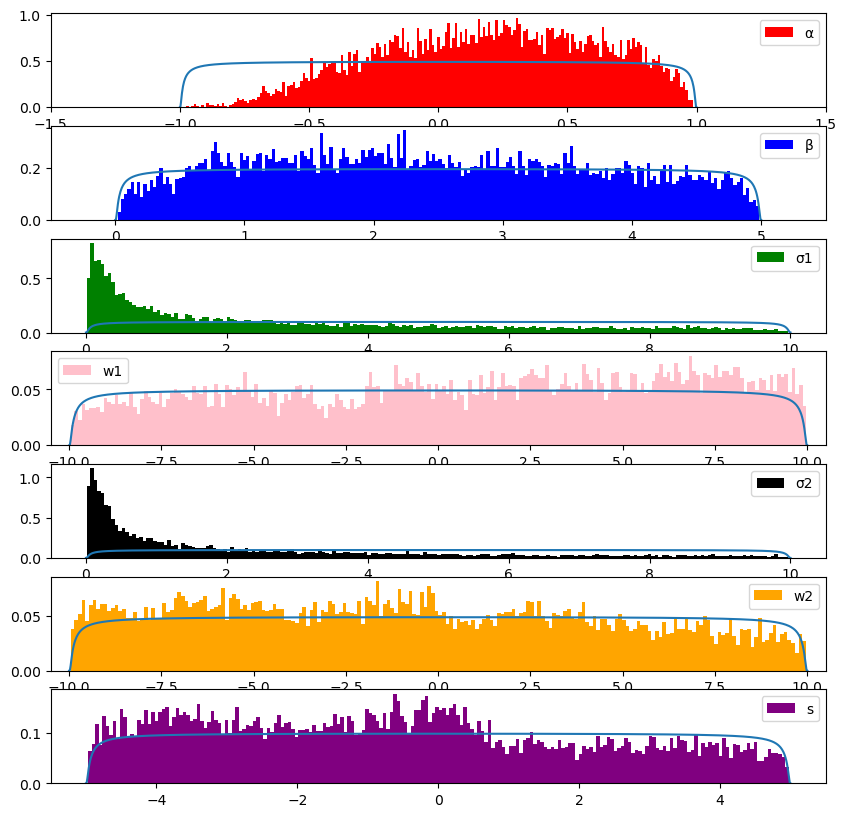

In [25]:
plothist(traceq[:],fits_comb[i],200,prior=True,burn=100,kernel='split')

In [44]:
i=9
fits_comb[i].pd_args=tuple(traceq[100:70000].mean(0)[:2].detach())
fits_comb[i].ker_args=tuple(traceq[100:10000].mode(0)[0][2:].detach())

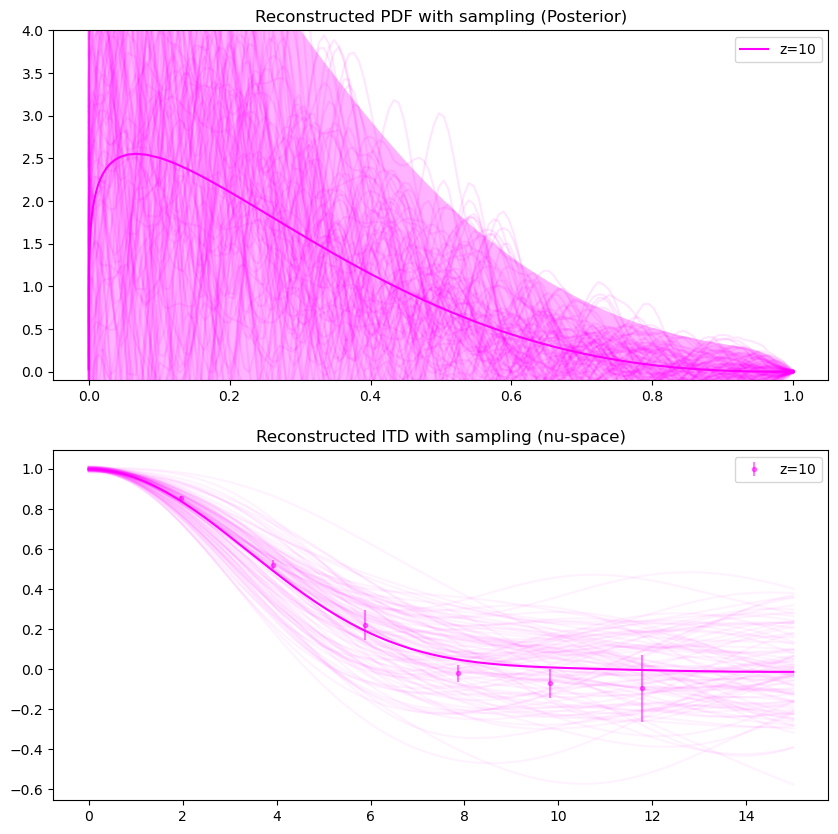

In [45]:
col=['red','blue','green','pink','black','orange','purple','brown','cyan','magenta','yellow','grey']
fig, ax= plt.subplots(2,figsize=(10, 10))
ax[0].set_title("Reconstructed PDF with sampling (Posterior)")
ax[1].set_title("Reconstructed ITD with sampling (nu-space)")
fe = FE2_Integrator(x_grid)
p,Cp = fits_comb[i].ComputePosterior()
Cp = 0.5*(Cp+Cp.T) +6e-5*tr.eye(Cp.shape[0])
Mc=tr.distributions.MultivariateNormal(p,covariance_matrix=Cp)
#plot the data
pdfMc = Mc.sample((100,))
ax[0].plot(x_grid,pdfMc.T.numpy(),alpha=0.1,color=col[i])
ax[0].plot(x_grid,fits_comb[i].Pd(fits_comb[i].x_grid,*fits_comb[i].pd_args).numpy(),label='z='+str(i+1),color=col[i])
perror=1.96*np.diag(Cp)**(0.5)
p=fits_comb[i].Pd(fits_comb[i].x_grid,*fits_comb[i].pd_args).numpy()
ax[0].fill_between(x_grid, p - perror, p + perror, facecolor=col[i], alpha=0.3)

ax[0].legend()
ax[0].set_ylim([-0.1,4])
#ax[0].ylim([-0.1,4])
nn = np.linspace(0,15,128)
iB = np.zeros((nn.shape[0],Nx))
for k in range(nn.shape[0]):
    iB[k,:] = fe.set_up_integration(Kernel= lambda x : np.cos(nn[k]*x))
ttQ = pdfMc.numpy()@iB.T
mttQ = ttQ.mean(axis=0)
ax[1].plot(nn,ttQ.T,color=col[i],alpha=0.05)
ax[1].plot(nn,mttQ,color=col[i])

plt.errorbar(nu.T[i],rM.T[i],yerr=rMe.T[i],fmt='.',alpha=0.5,label='z='+str(i+1),color=col[i])
plt.legend()
plt.show()

In [60]:
for i in range(11):
    file_name = f"tensor_{i}.txt"

    with open(file_name, "w") as f:
        for row in traceq:
            f.write(" ".join(map(str, row.tolist())) + "\n")

In [12]:
import sys

def check_memory():
    ipython_vars = ["In", "Out", "exit", "quit", "get_ipython", "ipython_vars"]
    
    print("Top 10 objects with highest memory usage")
    
    # Get a sorted list of the objects and their sizes
    mem = {
        key: round(value/1e6,2)
        for key, value in sorted(
            [
                (x, sys.getsizeof(globals().get(x)))
                for x in globals()
                if not x.startswith("_") and x not in sys.modules and x not in ipython_vars
            ],
            key=lambda x: x[1],
            reverse=True)[:10]
    }
    print({key:f"{value} MB" for key,value in mem.items()})
    
    print(f"\n{round(sum(mem.values()),2)} MB in use overall")

In [40]:
#memory of traceq
traceq.nbytes/1e6 *8

4.48

In [22]:
check_memory()

Top 10 objects with highest memory usage
{'rMj': '0.2 MB', 'V0': '0.02 MB', 'm_4': '0.0 MB', 'm_6': '0.0 MB', 'm_8': '0.0 MB', 'm': '0.0 MB', 'x_grid': '0.0 MB', 'x_gri0': '0.0 MB', 'HMC_sampler': '0.0 MB', 'Bounds': '0.0 MB'}

0.22 MB in use overall


In [10]:
uwu=tr.tensor([0.2,1.0,1.0,1.1,8.0,1.1,9.0])
rand=tr.rand(7)*5
px=tr.tensor([0.2,1.0])
kx=tr.tensor([1.0,1.1,8.0,1.1,9.0])
myGP0.nlpEvidence(px,kx)

tensor(-0.2933, device='cuda:0')

## Check grads

In [14]:
start = time.time()
random= tr.rand(7)*6
res=myGP0.gradlogpost2levelpdf(random)
end = time.time()
print(end-start,res)

0.04233884811401367 tensor([ 0.9963, -1.1584,  0.5504,  0.6068,  0.5017,  1.6666,  0.2772])


In [16]:
def Evi(x):
    return myGP0.nlpEvidence(x[:2],x[2:])

In [16]:
#time the gradient
start = time.time()
resa=autograd(myGP0.nlogpost2levelpdf,random)
end = time.time()
print(end-start,resa)

0.06955385208129883 tensor([ 0.9963, -1.1584,  0.5504,  0.6068,  0.5017,  1.6666,  0.2772])


In [17]:
print(resa-res)

tensor([ 1.1921e-07,  0.0000e+00,  0.0000e+00,  1.1921e-07, -5.9605e-08,
         0.0000e+00,  2.9802e-08])
